In [1]:
import re
import nltk
import string

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm.auto import tqdm

In [2]:
np.random.seed(0)

In [3]:
lemmatizer = nltk.stem.WordNetLemmatizer()

In [4]:
with open('../../data/Sentences_AllAgree.txt', 'r', encoding="ISO-8859-1") as f:
    raw_data = f.read()

In [5]:
lines = raw_data.split('\n')

In [6]:
label_mapping = {
    'negative': -1,
    'neutral': 0,
    'positive': +1
}

In [7]:
sentences = []
labels = []
for line in lines[:-1]:
    sentence, label = line.split('@')
    sentences.append(sentence)
    labels.append(label_mapping[label])

In [8]:
sentences = np.array(sentences)
labels = np.array(labels)

In [9]:
u, c = np.unique(labels, return_counts=True)
print(u, c, c / c.sum())

[-1  0  1] [ 303 1391  570] [0.13383392 0.61439929 0.25176678]


In [10]:
def preprocess(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    # text = re.sub(r'[0-9]+', '', text)
    text = text.replace('  ', ' ')
    
    return text

In [11]:
def tokenize(text):
    text = preprocess(text)
    tokens = nltk.tokenize.word_tokenize(text)
    tokens = [lemmatizer.lemmatize(t) for t in tokens if t not in nltk.corpus.stopwords.words('english')]
    
    return tokens

In [12]:
all_words = []
for x in tqdm(sentences):
    all_words.extend(tokenize(x))

  0%|          | 0/2264 [00:00<?, ?it/s]

In [13]:
vocabulary, frequencies = np.unique(np.array(all_words), return_counts=True)
ind_sort = frequencies.argsort()
vocabulary = vocabulary[ind_sort]
frequencies = frequencies[ind_sort]

In [14]:
vocabulary_dict = {
    w: i for i, w in enumerate(vocabulary)
}

In [15]:
def partition_labels(labels):
    # Vector with (0, ..., n-1)
    ind = np.arange(len(labels))
    
    # Gets unique classes
    unique_labels = np.unique(labels)
    
    train_indices = []
    test_indices = []
    for yu in unique_labels:
        ind_yu = np.where(labels == yu)[0]
        
        n_tr = int(0.80 * len(ind_yu))

        # Shuffle indices
        np.random.shuffle(ind_yu)
        
        # adds to train/dev/test sets
        train_indices.append(ind_yu[:n_tr])
        test_indices.append(ind_yu[n_tr:])
    # Concatenate indices
    train_indices = np.concatenate(train_indices)
    test_indices = np.concatenate(test_indices)
    
    return train_indices, test_indices

In [16]:
i_tr, i_ts = partition_labels(labels)

print('Amount of samples per partition: ', len(i_tr), len(i_ts))
print('Proportions per partition: ',
      len(i_tr) / len(sentences),
      len(i_ts) / len(sentences))

Amount of samples per partition:  1810 454
Proportions per partition:  0.799469964664311 0.20053003533568906


In [17]:
train_sentences = sentences[i_tr]
test_sentences = sentences[i_ts]

ytr = labels[i_tr]
yts = labels[i_ts]

In [18]:
u, c = np.unique(ytr, return_counts=True)
print(c / c.sum())

[0.13370166 0.61436464 0.2519337 ]


In [19]:
u, c = np.unique(yts, return_counts=True)
print(c / c.sum())

[0.13436123 0.61453744 0.25110132]


In [20]:
def create_bow_vector(text):
    x = np.zeros([1, len(vocabulary_dict)])
    words = tokenize(text)
    ret = np.unique(np.array(words), return_counts=True)
    unique_words, frequencies_words = np.unique(words, return_counts=True)
    
    for wij, fij in zip(unique_words, frequencies_words):
        if wij in vocabulary_dict:
            x[0, vocabulary_dict[wij]] = fij
        else:
            print(text)
            print(f'Word {wij} is not in the vocabulary')
        
    return x / (x.sum() + 1e-11)

In [21]:
Xtr_bow = []
for x in tqdm(train_sentences):
    Xtr_bow.append(create_bow_vector(x))
Xtr_bow = np.concatenate(Xtr_bow, axis=0)

  0%|          | 0/1810 [00:00<?, ?it/s]

In [22]:
Xts_bow = []
for x in tqdm(test_sentences):
    Xts_bow.append(create_bow_vector(x))
Xts_bow = np.concatenate(Xts_bow, axis=0)

  0%|          | 0/454 [00:00<?, ?it/s]

In [23]:
D = 1 - ((np.dot(Xtr_bow, Xts_bow.T)) /
         ((np.linalg.norm(Xtr_bow, axis=1)[:, None] + 1e-11) *
          (np.linalg.norm(Xts_bow, axis=1)[None, :] + 1e-11)))
print(D.shape)

(1810, 454)


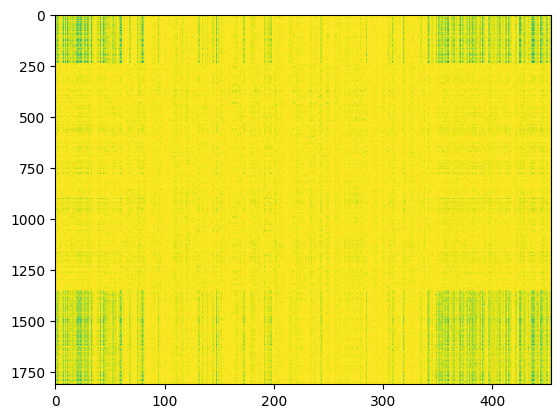

In [24]:
plt.imshow(D[ytr.argsort(), :][:, yts.argsort()], aspect='auto')

In [25]:
i_opt = D.argmin(axis=0)
y_pred = ytr[i_opt]

In [26]:
acc = (1 * (y_pred == yts)).sum() / len(yts)
print(acc)

0.7577092511013216


In [27]:
for yu in np.unique(labels):
    ind = np.where(yts == yu)[0]
    acc = (1 * (y_pred[ind] == yts[ind])).sum() / len(yts[ind])
    
    print(f'Class {yu}, acc: {acc}')

Class -1, acc: 0.5245901639344263
Class 0, acc: 0.8781362007168458
Class 1, acc: 0.5877192982456141


In [28]:
term_frequency = np.zeros([len(train_sentences), len(vocabulary_dict)])

for i, sentence in tqdm(enumerate(train_sentences), total=len(train_sentences)):
    tokens = tokenize(sentence)
    wi, ci = np.unique(tokens, return_counts=True)
    
    for wij, cij in zip(wi, ci):
        if wij in vocabulary_dict:
            term_frequency[i, vocabulary_dict[wij]] = 1

  0%|          | 0/1810 [00:00<?, ?it/s]

In [29]:
term_frequency.sum(axis=0).shape

(6185,)

In [30]:
doc_frequency = term_frequency.sum(axis=0)
tf = term_frequency / (term_frequency.sum(axis=1)[:, None] + 1e-11)
idf = np.log(len(train_sentences) / (doc_frequency + 1e-11))

X_tr_tfidf = tf * idf

In [31]:
term_frequency = np.zeros([len(test_sentences), len(vocabulary_dict)])

for i, sentence in tqdm(enumerate(test_sentences), total=len(test_sentences)):
    tokens = tokenize(sentence)
    wi, ci = np.unique(tokens, return_counts=True)
    
    for wij, cij in zip(wi, ci):
        if wij in vocabulary_dict:
            term_frequency[i, vocabulary_dict[wij]] = 1
doc_frequency = term_frequency.sum(axis=0)
tf = term_frequency / (term_frequency.sum(axis=1)[:, None] + 1e-11)
idf = np.log(len(test_sentences) / (doc_frequency + 1e-11))

X_ts_tfidf = tf * idf

  0%|          | 0/454 [00:00<?, ?it/s]

In [32]:
D = 1 - ((np.dot(X_tr_tfidf, X_ts_tfidf.T)) /
         ((np.linalg.norm(X_tr_tfidf, axis=1)[:, None] + 1e-11) *
          (np.linalg.norm(X_ts_tfidf, axis=1)[None, :] + 1e-11)))
print(D.shape)

(1810, 454)


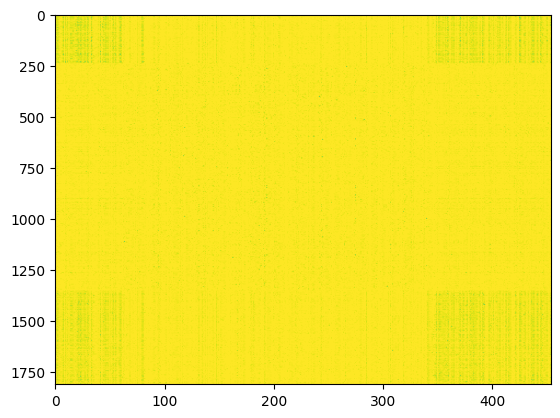

In [33]:
plt.imshow(D[ytr.argsort(), :][:, yts.argsort()], aspect='auto')

In [34]:
i_opt = D.argmin(axis=0)
y_pred = ytr[i_opt]

In [35]:
acc = (1 * (y_pred == yts)).sum() / len(yts)
print(acc)

0.73568281938326


In [36]:
for yu in np.unique(labels):
    ind = np.where(yts == yu)[0]
    acc = (1 * (y_pred[ind] == yts[ind])).sum() / len(yts[ind])
    
    print(f'Class {yu}, acc: {acc}')

Class -1, acc: 0.5081967213114754
Class 0, acc: 0.8458781362007168
Class 1, acc: 0.5877192982456141


In [38]:
term_frequency = np.zeros([len(train_sentences), len(vocabulary_dict)])

for i, sentence in tqdm(enumerate(train_sentences), total=len(train_sentences)):
    tokens = tokenize(sentence)
    wi, ci = np.unique(tokens, return_counts=True)
    
    for wij, cij in zip(wi, ci):
        if wij in vocabulary_dict:
            term_frequency[i, vocabulary_dict[wij]] = 1
doc_frequency = term_frequency.sum(axis=0)
tf = np.log(1 + term_frequency / (term_frequency.sum(axis=1)[:, None] + 1e-11))
idf = np.log(len(train_sentences) / (doc_frequency + 1)) + 1

X_tr_tfidf = tf * idf

  0%|          | 0/1810 [00:00<?, ?it/s]

In [39]:
term_frequency = np.zeros([len(test_sentences), len(vocabulary_dict)])

for i, sentence in tqdm(enumerate(test_sentences), total=len(test_sentences)):
    tokens = tokenize(sentence)
    wi, ci = np.unique(tokens, return_counts=True)
    
    for wij, cij in zip(wi, ci):
        if wij in vocabulary_dict:
            term_frequency[i, vocabulary_dict[wij]] = 1
doc_frequency = term_frequency.sum(axis=0)
tf = np.log(1 + term_frequency / (term_frequency.sum(axis=1)[:, None] + 1e-11))
idf = np.log(len(test_sentences) / (doc_frequency + 1)) + 1

X_ts_tfidf = tf * idf

  0%|          | 0/454 [00:00<?, ?it/s]

In [40]:
D = 1 - ((np.dot(X_tr_tfidf, X_ts_tfidf.T)) /
         ((np.linalg.norm(X_tr_tfidf, axis=1)[:, None] + 1e-11) *
          (np.linalg.norm(X_ts_tfidf, axis=1)[None, :] + 1e-11)))
print(D.shape)

(1810, 454)


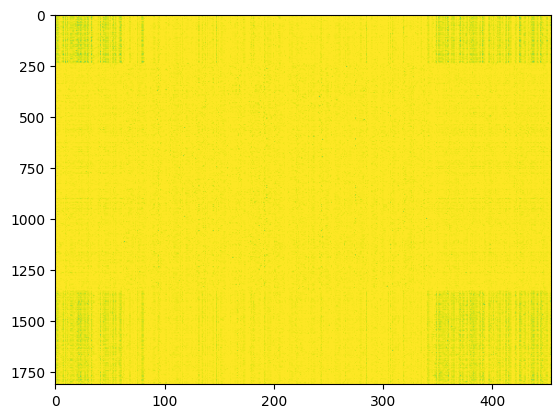

In [41]:
plt.imshow(D[ytr.argsort(), :][:, yts.argsort()], aspect='auto')

In [42]:
i_opt = D.argmin(axis=0)
y_pred = ytr[i_opt]

In [43]:
acc = (1 * (y_pred == yts)).sum() / len(yts)
print(acc)

0.7444933920704846


In [44]:
for yu in np.unique(labels):
    ind = np.where(yts == yu)[0]
    acc = (1 * (y_pred[ind] == yts[ind])).sum() / len(yts[ind])
    
    print(f'Class {yu}, acc: {acc}')

Class -1, acc: 0.5737704918032787
Class 0, acc: 0.8494623655913979
Class 1, acc: 0.5789473684210527


In [45]:
from sklearn.decomposition import TruncatedSVD

In [46]:
pca = TruncatedSVD(n_components=2)

In [47]:
pca.fit(Xtr_bow)

TruncatedSVD()

In [48]:
proj = pca.transform(np.concatenate([Xtr_bow, Xts_bow], axis=0))

In [49]:
y = np.concatenate([ytr, yts], axis=0)

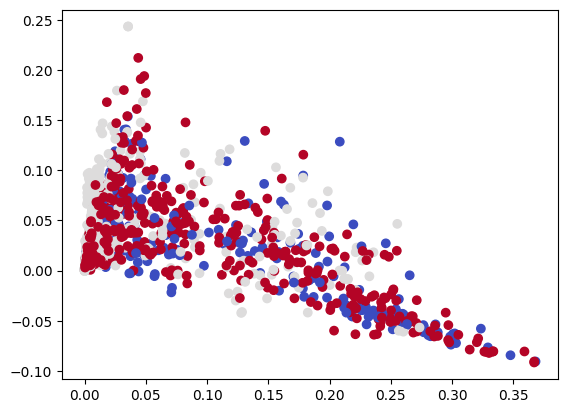

In [50]:
plt.scatter(proj[:, 0], proj[:, 1], c=y, cmap=plt.cm.coolwarm)

In [51]:
from sklearn.manifold import TSNE

In [52]:
proj = TSNE(n_components=2, verbose=True).fit_transform(np.concatenate([Xtr_bow, Xts_bow], axis=0))

/home/efernand/anaconda3/envs/OptimalTransport/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/efernand/anaconda3/envs/OptimalTransport/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2264 samples in 0.005s...
[t-SNE] Computed neighbors for 2264 samples in 0.397s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2264
[t-SNE] Computed conditional probabilities for sample 2000 / 2264
[t-SNE] Computed conditional probabilities for sample 2264 / 2264
[t-SNE] Mean sigma: 0.095326
[t-SNE] KL divergence after 250 iterations with early exaggeration: 131.676392
[t-SNE] KL divergence after 1000 iterations: 2.811350


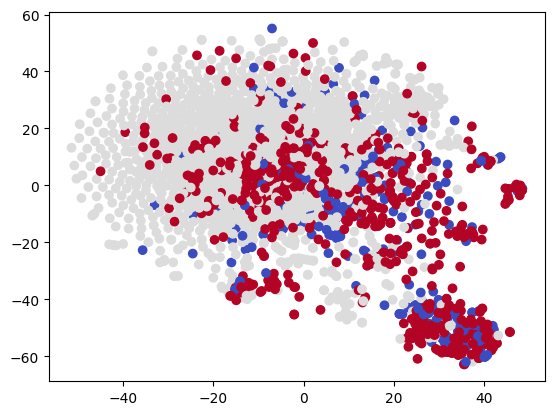

In [53]:
plt.scatter(proj[:, 0], proj[:, 1], c=y, cmap=plt.cm.coolwarm)

In [54]:
proj = TSNE(n_components=2, verbose=True, metric='cosine').fit_transform(
    np.concatenate([Xtr_bow, Xts_bow], axis=0))

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2264 samples in 0.005s...


/home/efernand/anaconda3/envs/OptimalTransport/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/efernand/anaconda3/envs/OptimalTransport/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computed neighbors for 2264 samples in 0.174s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2264
[t-SNE] Computed conditional probabilities for sample 2000 / 2264
[t-SNE] Computed conditional probabilities for sample 2264 / 2264
[t-SNE] Mean sigma: 0.232812
[t-SNE] KL divergence after 250 iterations with early exaggeration: 78.453506
[t-SNE] KL divergence after 1000 iterations: 1.988689


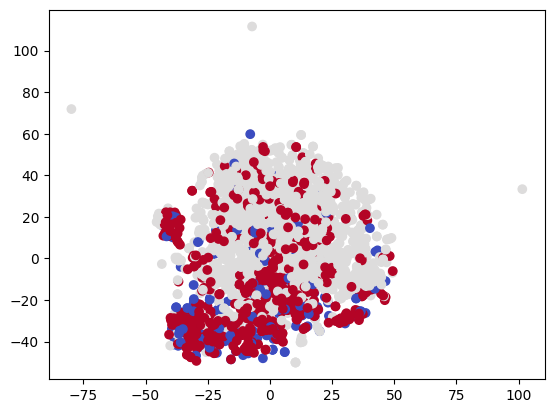

In [55]:
plt.scatter(proj[:, 0], proj[:, 1], c=y, cmap=plt.cm.coolwarm)